In [9]:
import numpy as np
import matplotlib.pyplot as plt
from expr import *
from mutator import *
from simplify import *

In [10]:
def random_expr(depth: int, options) -> Expression:
    if depth == 0:
        if np.random.choice(2) == 0:
            return ConstantExpression(np.random.randint(1, 10))
        else:
            return VariableExpression("x")
    else:
        op = np.random.choice(options["BINARY_OPERATORS"])
        expr = BinaryExpression(op, random_expr(depth - 1, options), random_expr(depth - 1, options))
        if np.random.choice(5) == 0:
            op = np.random.choice(options["UNARY_OPERATORS"])
            expr = UnaryExpression(op, expr)
        return expr
    
def random_formula(depth: int, options) -> Formula:
    expr = SimplifierVisitor().visit(random_expr(depth, options))
    return Formula(expr)

## Input data

In [11]:
N = 1000
X = np.linspace(0, 1, N)
Y = np.sin(4 * X) + 0.5 * X

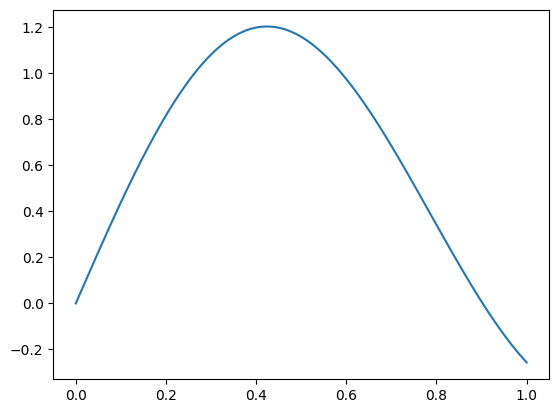

In [12]:
plt.plot(X, Y)
plt.show()

## Regression

In [13]:
import copy

In [16]:
MAX_DEPTH = 3
K_BEST = 5
POPULATION_SIZE = 2000
EPOCHS = 5
OPTIONS = {
    "BINARY_OPERATORS": [ BinaryOp.ADD, BinaryOp.MUL ], 
    "UNARY_OPERATORS": [ UnaryOp.SIN, UnaryOp.SQRT, UnaryOp.TAN ]
}

def loss(formula, eta: float = 0.04):
    predicted_y = formula(X)
    l = (1 - eta) * np.mean((Y - predicted_y) ** 2) + eta * formula.complexity
    if np.isnan(l):
        return np.inf
    else:
        return l

formulas = [ random_formula(MAX_DEPTH, OPTIONS) for _ in range(POPULATION_SIZE) ]
best_formula_indices = np.argpartition([ loss(formula) for formula in formulas ], K_BEST)[:K_BEST]
best_formulas = [ formulas[index] for index in best_formula_indices ]
for formula in best_formulas:
    print(formula)

p = np.array([ 3, 2, 2, 5, 1 ])
p = p / np.sum(p)
mutator = RandomMutator(
        [ 
            ConstantNoiseMutator(),
            BinaryOperatorMutator(OPTIONS["BINARY_OPERATORS"]),
            UnaryOperatorMutator(OPTIONS["UNARY_OPERATORS"]),
            UnaryDeleterMutator(p=1),
            BinaryDeleterMutator(p=1)
        ], p)

for i in range(EPOCHS):
    formulas = [ copy.deepcopy(np.random.choice(best_formulas)) for _ in range(int(POPULATION_SIZE * 0.8)) ]
    for _ in range(int(POPULATION_SIZE * 0.2)):
        formulas.append(random_formula(MAX_DEPTH, OPTIONS))

    best_formula = best_formulas[np.argmin([loss(f) for f in best_formulas])]
    print(f"EPOCH {i}: {loss(best_formula)}: {best_formula}")
    for formula in formulas:
        mutator.mutate(formula)
    best_formula_indices = np.argpartition([ loss(formula) for formula in formulas ], K_BEST)[:K_BEST]
    best_formulas = [ formulas[index].simplify() for index in best_formula_indices ]

sin((x + 2 * x) + x ^ 2 * tan(x + 9))
sin(((x + 8) + sqrt(x + 2)) + (2 * x + (x + 3)))
sin((2 * x + sin(x + 9)) + sin(7 * x + 11))
sin(sqrt((x + 8) * (x + 7)) + 0.49265374649621935)
(sin(x + 3) + 0.6569865987187891) * (x ^ 2 + sqrt(2 * x))
EPOCH 0: 0.23104051899748576: sin((x + 2 * x) + x ^ 2 * tan(x + 9))
EPOCH 1: 0.19005411345585488: 0.6569865987187891
EPOCH 2: 0.19005278352405347: 0.6681261207624642
EPOCH 3: 0.1900360892194924: 0.6662162532067506
EPOCH 4: 0.1900236705958534: 0.6625321428129572


sin(4x) + 0.5x
sin(((x + 9.651267266639628) + 4.800985892780782) + (48.68341298861147 + (x + x)))
0.17868297398414004


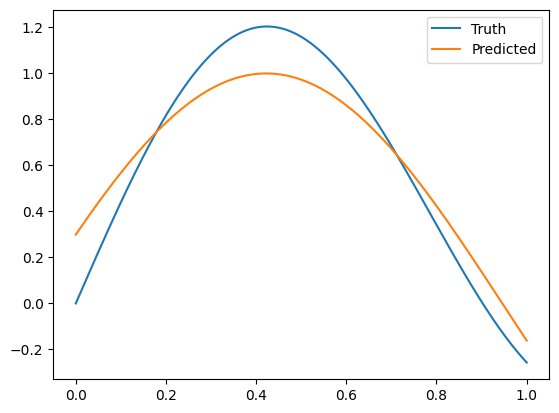

In [15]:
print("sin(4x) + 0.5x")
print(best_formula)
print(loss(best_formula))
plt.plot(X, Y, label="Truth")
plt.plot(X, best_formula(X), label="Predicted")
plt.legend()
plt.show()

In [16]:
import sympy as sp

# Regression

In [3]:
from dataclasses import dataclass

@dataclass
class Options:
    min_depth: int = 1
    """The minimum depth for generating mathematical expressions."""

    max_depth: int = 3
    """The maximum depth for generating mathematical expressions."""

    population_size: int = 500
    """Size of a population at each generation. Too large population may slow down considerably the system."""

    k_best: int = 5
    """The count of best candidates to be considered to generate the new generation."""

    iterations: int = 10
    """Count of iterations (generations) to simulate."""

    show_every: int = 1
    """Show information and the best canditate at every requested generation. Set to None to hide intermediate information."""

    # generate: Generator = None

    crossover_rate: float = 0.05
    """Probability to generate a formula in the new generation using cross-over (picking random parts from two formulas
    of the previous generation)."""

    # TODO: implement crossover
    # crossover: Crossover = None

    mutation_rate: float = 0.95
    """Probability to generate a formula in the new generation using mutation from a formula of the previous generation."""

    # TODO: implement mutator
    # mutator: Mutator = None


In [4]:
def fitness(formula: Formula, x, y) -> float:
  """Computes the mean squared error (MSE)."""
  predicted_y = formula(x)
  return np.mean((y - predicted_y) ** 2)

def run(x, y, options: Options):
  # Generate initial population
  generation = [ options.generator.generate() for _ in range(options.population_size) ]

  crossover_count = int(options.crossover_rate * options.population_size)
  mutation_count = int(options.mutation_rate * options.population_size)
  random_count = options.population_size - crossover_count - mutation_count
  
  random_generator = np.random.default_rng()

  for i in range(options.iterations):
    best_candidates_indices = np.argpartition([ fitness(f, x, y) for f in generation ], options.k_best)
    best_candidates = generation[best_candidates_indices]

    generation = []

    # Generate formulas by recombining random parts of the previous best candidates (cross-over)
    for _ in range(crossover_count):
      # TODO: implement crossover
      # formula = options.crossover.crossover(best_candidates)
      # generation.append()
      pass

    # Generate formulas by applying random mutations to the previous best candidates (mutations)
    for _ in range(mutation_count):
      formula = random_generator.choice(best_candidates)
      options.mutator.mutate(formula)
      generation.append(formula)

    # Generate completely new random formulas
    for _ in range(random_count):
      formula = options.generator.generate()
      generation.append(formula)

    if i % options.show_every == 0:
      print(f"Iteration {i}:")
      for j, candidate in enumerate(best_candidates):
        print(f"  Best candidate {j}:")
        print(f"    Formula: {candidate}")
        print(f"    Fitness: {fitness(candidate, x, y)}")

  best_candidates_indices = np.argpartition([ fitness(f, x, y) for f in generation ], options.k_best)
  best_candidates = generation[best_candidates_indices]
  return best_candidates

NameError: name 'Formula' is not defined